# Estimation des paramètres

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics


In [2]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

Importation du corpus.

In [28]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


### Estimation du seuil de la distance de Levenshtein normalisée

In [3]:
corpus_test = corpus[['text','publication_time']].sample(n= 100, random_state = 42)

In [4]:
def nb_per_thresholds(
    corus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,20)
    dist = textdistance.levenshtein.normalized_distance
    for limit in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus_test['text'].tolist(),corpus_test['publication_time'].tolist(),limit,dist)))
    return thresholds,nb_remaing_posts
        

In [5]:
x,y = nb_per_thresholds(corpus_test)


In [11]:
y = [i*100/max(y) for i in y]

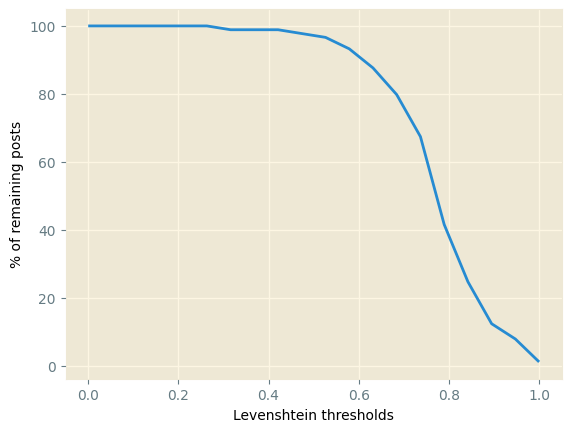

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
with plt.style.context('Solarize_Light2'):
    plt.plot(x, y)
    plt.xlabel('Levenshtein thresholds')
    plt.ylabel('% of remaining posts')

In [26]:
def get_duplicates(
    corpus: list, 
    limit: float, 
    method: callable
    ):
    originals = []
    copies = []
    t = [utilities.clean_hashtag(s).strip() for s in corpus]
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(t[i],t[j]) <= limit ): # Si la distance entre les deux élemens de la liste inf à seuil
                originals.append(t[i])
                copies.append([t[j]])
                break
            j+=1
        i+=1
    return pd.DataFrame({'originals' : originals , 'copies' : copies})

In [32]:
dist = textdistance.levenshtein.normalized_distance
originlas_copies = get_duplicates(corpus['text'].sample(n= 50, random_state = 42).tolist(),0.6,dist)

In [47]:
def get_duplicates_per_thresholds():
    list_duplicates_per_thresholds = []
    list_thresholds = np.linspace(0.4,1,13)
    dist = textdistance.levenshtein.normalized_distance
    for thresholds in list_thresholds:
        list_duplicates_per_thresholds.append(get_duplicates(corpus['text'].sample(n= 50, random_state = 10).tolist(),thresholds,dist))
    return pd.DataFrame({'threshold' : list_thresholds , 'duplicates' : list_duplicates_per_thresholds})

In [50]:
df_dup_per_thesh = get_duplicates_per_thresholds()

In [51]:
df_dup_per_thesh

,threshold,duplicates
0,0.40,ori...
1,0.45,ori...
2,0.50,ori...
3,0.55,ori...
4,0.60,ori...
5,0.65,ori...
6,0.70,or...
7,0.75,or...
8,0.80,or...
9,0.85,or...


### Optimisation paramètres de l'arbre de décision

In [7]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
train,test = utilities.train_test(data = chanel_all_features.dropna().drop('text',axis=1), y = 'is_junk', f_y0= 0.7, f_y1= 0.7)
X_train = train.drop('is_junk',axis=1)
y_train = train['is_junk']
X_test = test.drop('is_junk',axis=1)
y_test = test['is_junk']


In [11]:
def optimize_ccp_alpha(X_train,X_test,y_train,y_test):    
    list_ccp_alpha = np.linspace(0.01,0.040,31)
    list_auc = []
    for ccp in list_ccp_alpha:
        tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=8, ccp_alpha = ccp, min_samples_leaf = 5)
        tree.fit(X_train,y_train)
        y_pred = tree.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        list_auc.append(metrics.auc(fpr, tpr))
    return list_ccp_alpha,list_auc 

Arbre 1 : 

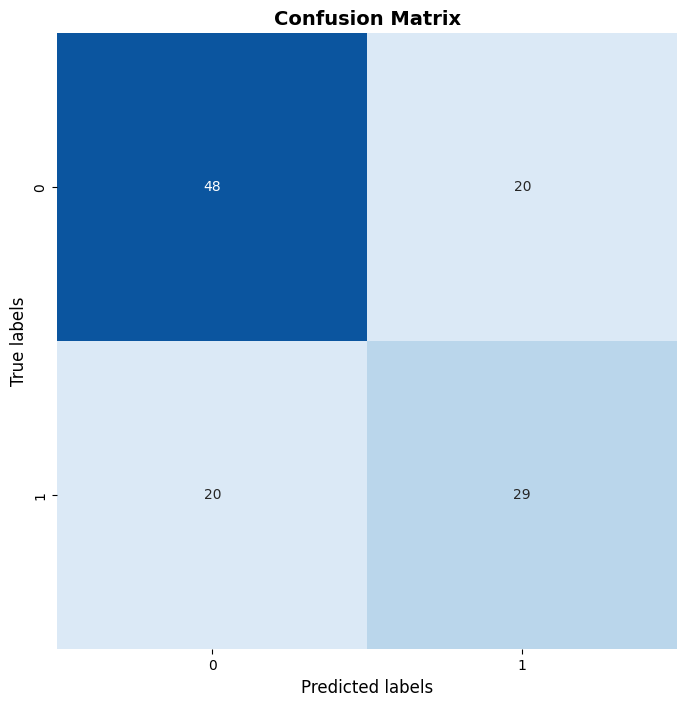

AUC : 0.648859543817527
Accuracy score : 0.6581196581196581


In [38]:
tree1 = DecisionTreeClassifier(criterion = 'gini')
tree1.fit(X_train,y_train)
y_pred = tree1.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 2

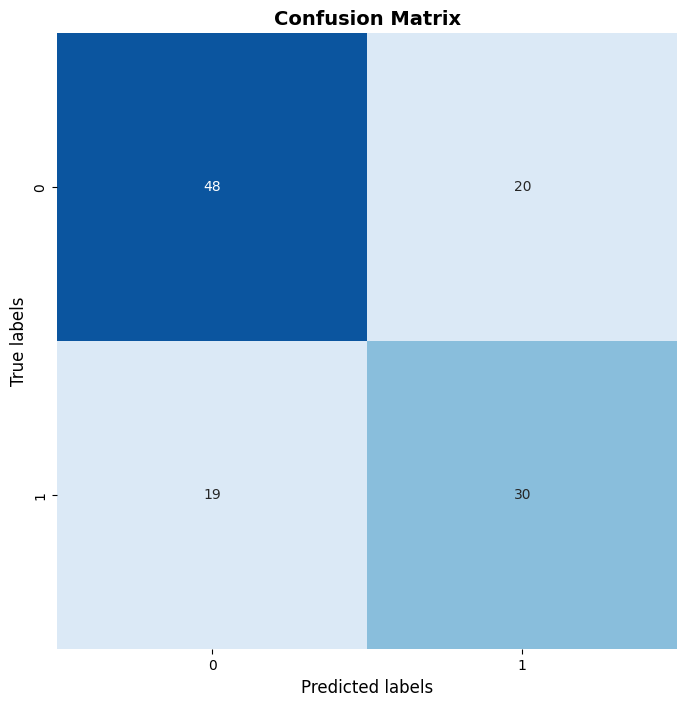

AUC : 0.65906362545018
Accuracy score : 0.6666666666666666


In [46]:
tree2 = DecisionTreeClassifier(criterion = 'entropy')
tree2.fit(X_train,y_train)
y_pred = tree2.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 3

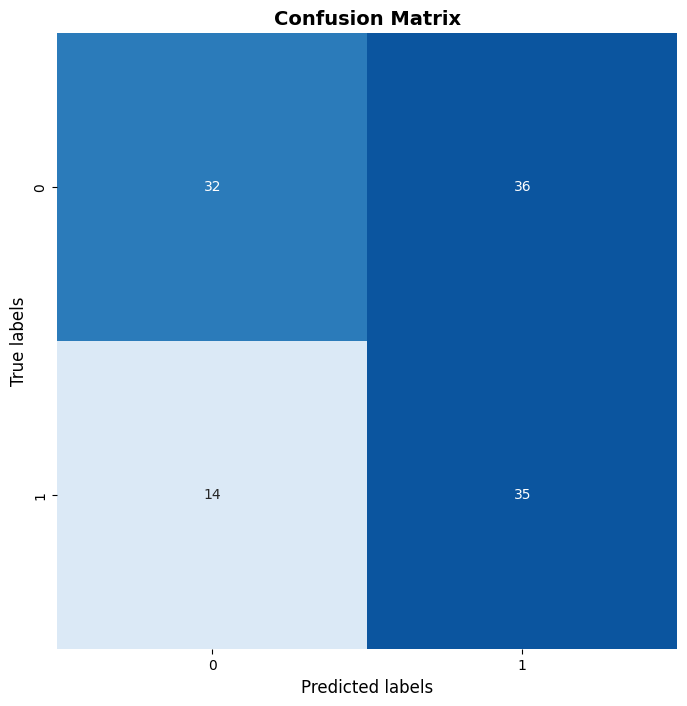

AUC : 0.592436974789916
Accuracy score : 0.5726495726495726


In [82]:
tree3 = DecisionTreeClassifier(criterion = 'entropy',class_weight = "balanced")
tree3.fit(X_train,y_train)
y_pred = tree3.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 4

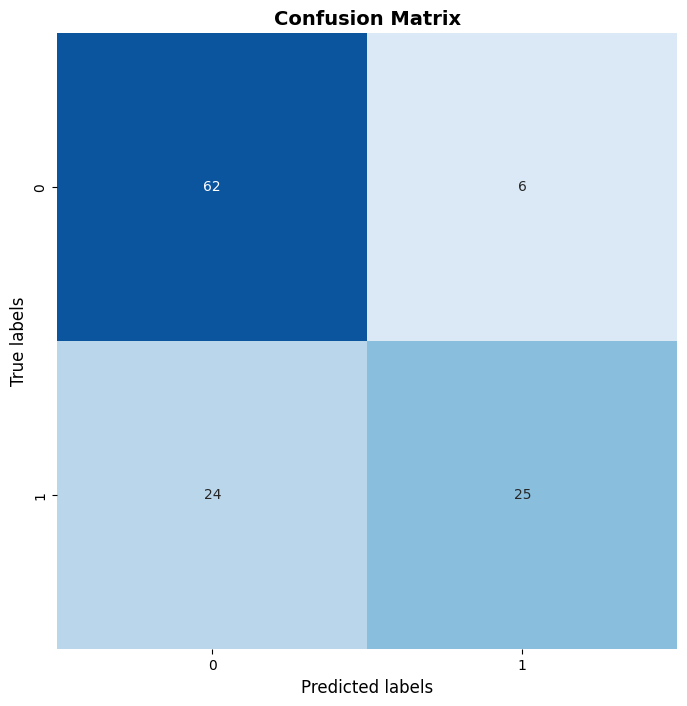

AUC : 0.710984393757503
Accuracy score : 0.7435897435897436


In [81]:
tree4 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
tree4.fit(X_train,y_train)
y_pred = tree4.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 5

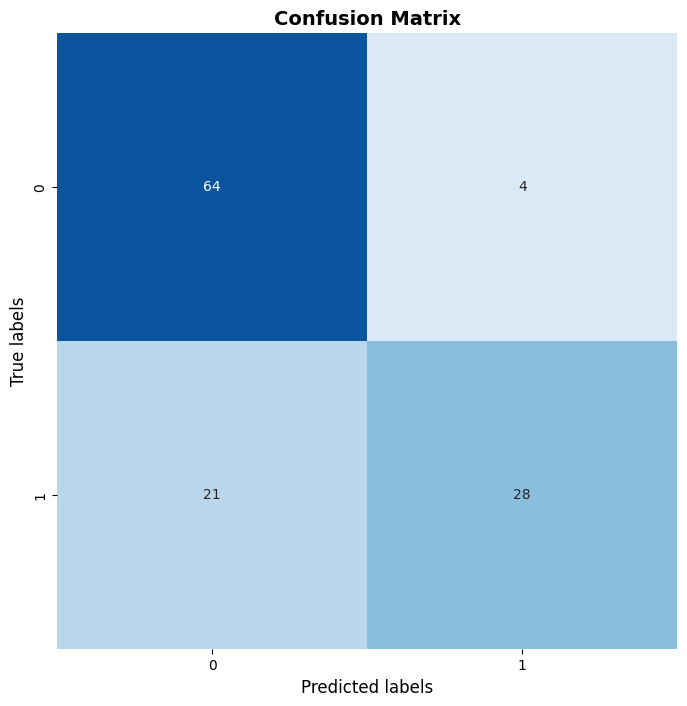

AUC : 0.7563025210084033
Accuracy score : 0.7863247863247863


In [130]:
tree5 = DecisionTreeClassifier(criterion = 'entropy', max_depth=8, ccp_alpha = 0.025, min_samples_leaf = 5)
tree5.fit(X_train,y_train)
y_pred = tree5.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

In [12]:
ccp = optimize_ccp_alpha(X_train,X_test,y_train,y_test)

In [13]:
ccp

(array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 ]),
 [0.695078031212485,
  0.695078031212485,
  0.6877250900360145,
  0.6877250900360145,
  0.6877250900360145,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.695078031212485,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434,
  0.6616146458583434])